Import modules



In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py 
import random
import math
from sklearn.metrics import accuracy_score

Loading Dataset

In [ ]:
with h5py.File('/content/drive/My Drive/DL/Assignment-1-Dataset/train_128.h5','r') as H: 
    data = np.copy(H['data'])
with h5py.File('/content/drive/My Drive/DL/Assignment-1-Dataset/train_label.h5','r') as H: 
    label = np.copy(H['label']) 
with h5py.File('/content/drive/My Drive/DL/Assignment-1-Dataset/test_128.h5','r') as H: 
    test = np.copy(H['data']) 

In [ ]:
# data.shape

In [ ]:
# no need to transform as it was transform in crossEntropyLossFunc
def labelToneHot(label):
    temp=np.zeros(10)
    temp[label]=1
    return temp

In [ ]:
# plt.imshow(data.reshape(data.shape[0],8,-1)[1])

Define the Activation class tool

In [ ]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def __logistic_deriv(self, a):
        return  a * (1 - a )
    #relu 
    def __relu(self,x):
        return np.maximum(0,x)
    #relu derivation
    def __relu_deriv(self,a):
        y = (a > 0) * 1
        return y
    #leakyrelu
    def __leakyrelu(self,x):
        return np.where(x > 0, x, x * 0.01)   
    #leakyrelu derivation
    def __leakyrelu_deriv(self,x):
        return np.where(x > 0, 1, 0.01)        

    # no need to use it was contained in loss function
    def __softmax(self,X):
        expZ = np.exp(X - np.max(X))
        return expZ/sum(expZ)
    # softmax derivation (abandon)
    def __softmax_deriv(self,a):
        x=softmax(a)
        s=x.reshape(-1,1)
        return (np.diagflat(s) - np.dot(s, s.T))
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'leakyrelu':
            self.f = self.__leakyrelu
            self.f_deriv = self.__leakyrelu_deriv

defien the optimator class

In [ ]:
class OPT:
   def __init__(self, name, momentum=0.9,rho2=0.999,rho1=0.9):
       self.name=name
       self.momentum=momentum
       self.rho2=rho2
       self.rho1=rho1

In [ ]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None): #activation_last_layer current active  activation: current+1 layer active
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=None
        if activation:
            self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv
        # initialize the weights and bias
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
            )
        if activation == 'logistic':
            self.W *= 4
        if activation == 'relu':
            self.W = np.random.uniform(
                low=-np.sqrt(6. / ( n_out)),
                high=np.sqrt(6. / ( n_out)),
                size=(n_in, n_out)
                )

        self.b = np.zeros(n_out,)
        
        #for normal mode
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # for momentum
        self.grad_W_past = np.zeros(self.W.shape)
        self.grad_b_past = np.zeros(self.b.shape)
        # for adam
        self.W_v= np.zeros(self.W.shape)
        self.b_v= np.zeros(self.b.shape)
        self.W_m= np.zeros(self.W.shape)
        self.b_m= np.zeros(self.b.shape)

        #for dropout
        self.dropW=None
        self.M=None
        self.output_layer=False
        self.dropOut=True
        self.delta=None

        #FOR BN
        self.cache=None
        self.gamma=np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_out,)
            )
        self.beta=np.zeros(n_out,)
        self.grad_gamma=np.zeros(self.gamma.shape)
        self.grad_beta=np.zeros(self.beta.shape)
        self.mean=None
        self.variance=None
        #for BN momentum
        self.grad_gamma_past=np.zeros(self.gamma.shape)
        self.grad_beta_past=np.zeros(self.beta.shape)
        #for BN adam
        self.gamma_v= np.zeros(self.gamma.shape)
        self.beta_v= np.zeros(self.beta.shape)
        self.gamma_m= np.zeros(self.gamma.shape)
        self.beta_m= np.zeros(self.beta.shape)

    def forward(self,input,isTest=False,p=0.5):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output=None
        if self.dropOut and self.output_layer == False and isTest==False:
            # print('FP dropout layer',self.W.shape,self.b.shape)
            self.dropW,self.dropB=self.Dropout(self.W,self.b,p)
            lin_output =np.dot(input,self.dropW)+self.dropB
        else:
            # print('FP output layer',self.W.shape,self.b.shape)
            lin_output = np.dot(input, self.W) + self.b


        ## we put BN func here before the activation
        if isTest ==False:
            bn_output,self.cache,mean,variance=self.batchnorm_forward(lin_output,self.gamma,self.beta)
            if self.mean is None:
                self.mean=mean
            else:
                self.mean=self.mean*0.9 + 0.1 * mean
            if self.variance is None:
                self.variance=variance
            else:
                self.variance=self.variance*0.9 + 0.1 * variance
        else:
            bn_output=self.batchnorm_forward_test(lin_output,self.gamma,self.beta,self.mean,self.variance)

        self.output = (
            bn_output if self.activation is None
            else self.activation(bn_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta,p=0.5, output_layer=False):
        # print('a',np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)))

        self.output_layer=output_layer
        delta_return=None

        #we put BN BP here 
        delta,self.grad_gamma,self.grad_beta=self.batchnorm_backward(delta,self.cache)


        #dropout BP here
        if self.dropOut and self.output_layer ==False:
            # print('BP dropout layer',self.W.shape,self.b.shape)
            self.delta=delta * self.M/p
        else:
            # print('BP output layer',self.W.shape,self.b.shape)
            self.delta=delta

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(self.delta))   # input(64*32)   delta(64*10) 
        self.grad_b = np.sum(self.delta,axis=0)  #(10,)

        if self.activation_deriv:
            # W(32*10)  
            delta_return = self.delta.dot(self.W.T) * self.activation_deriv(self.input)

        return delta_return

    def batchnorm_forward_test(self,x,gamma,beta,mean,variance,eps=1e-5):
        N, D = x.shape
        # #step1: calculate mean
        # mu = 1./N * np.sum(x, axis = 0)
        #step2: subtract mean vector of every trainings example
        xmu = x - mean
        #step3: following the lower branch - calculation denominator
        sq = xmu ** 2
        # #step4: calculate variance
        # var = 1./N * np.sum(sq, axis = 0)
        #step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(variance + eps)
        #step6: invert sqrtwar
        ivar = 1./sqrtvar
        #step7: execute normalization
        xhat = xmu * ivar
        #step8: Nor the two transformation steps
        gammax = gamma * xhat
        #step9
        out = gammax + beta
        # #store intermediate
        # cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
        return out


    def batchnorm_forward(self,x, gamma, beta, eps=1e-5):
        N, D = x.shape
        #step1: calculate mean
        mu = 1./N * np.sum(x, axis = 0)
        #step2: subtract mean vector of every trainings example
        xmu = x - mu
        #step3: following the lower branch - calculation denominator
        sq = xmu ** 2
        #step4: calculate variance
        var = 1./N * np.sum(sq, axis = 0)
        #step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(var + eps)
        #step6: invert sqrtwar
        ivar = 1./sqrtvar
        #step7: execute normalization
        xhat = xmu * ivar
        #step8: Nor the two transformation steps
        gammax = gamma * xhat
        #step9
        out = gammax + beta
        #store intermediate
        cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
        mean=mu
        variance=var
        return out, cache , mean , variance

    def batchnorm_backward(self,dout, cache):
        #unfold the variables stored in cache
        xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache
        #get the dimensions of the input/output
        N,D = dout.shape
        #step9
        dbeta = np.sum(dout, axis=0)
        dgammax = dout #not necessary, but more understandable
        #step8
        dgamma = np.sum(dgammax*xhat, axis=0)
        dxhat = dgammax * gamma
        #step7
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar
        #step6
        dsqrtvar = -1. /(sqrtvar**2) * divar
        #step5
        dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar
        #step4
        dsq = 1. /N * np.ones((N,D)) * dvar
        #step3
        dxmu2 = 2 * xmu * dsq
        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
        #step1
        dx2 = 1. /N * np.ones((N,D)) * dmu
        #step0
        dx = dx1 + dx2
        return dx, dgamma, dbeta

    # dropout method
    def Dropout(self,W,B,p):
        self.M=np.random.binomial(1,p,size=W.shape[1])
        # scaled-up by 1/p
        W_new=(self.M*(W/p))
        B_new=(self.M*(B/p))
        return W_new,B_new
    #set output layer flag
    def is_output_layer(self,boolean):
        self.output_layer=boolean
    #set open dropout flag
    def set_Dropout(self,boolean):
        self.dropOut=boolean


In [ ]:
class MLP:
    """
    """      
    def __init__(self, layers, activation,dropout=True):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        print(len(layers)-1)
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

        self.layers[-1].is_output_layer(True)    

        for layer in self.layers:
            layer.set_Dropout(dropout) 

    def forward(self,input,isTest=False,p=0.5):
        for layer in self.layers:
            output=layer.forward(input,isTest,p=p)
            input=output    

        return output

    def criterion_MSE(self,y,y_hat):

        activation_deriv=None
        if self.activation[-1]:
            activation_deriv=Activation(self.activation[-1]).f_deriv
            
        error = self.delta_cross_entropy(y_hat,y)
        loss= self.cross_entropy( y_hat,y )

        # calculate the delta of the output layer   
        if activation_deriv:
            delta= error * activation_deriv(y_hat)
        else:
            delta=error
        # return loss and delta
        return loss,delta
        
    def backward(self,delta,p=0.5):
        # BP progress
        delta=self.layers[-1].backward(delta,output_layer=True,p=p)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta,p=p)
            
    def update(self,lr,epoch,opt=None,epsilon=1e-8,weight_decay=False,lamda=1):
        for layer in self.layers:
            #normal mode
            if opt is None:
                #using weight decay
                if weight_decay==True:
                    layer.W = (1-lr*lamda) * layer.W - lr * layer.grad_W
                else:
                    layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b # why [0] ???

                #using weight decay
                if weight_decay==True:
                    layer.gamma = (1-lr*lamda) * layer.gamma - lr * layer.grad_gamma
                else:
                    layer.gamma -= lr * layer.grad_gamma
                layer.beta -= lr * layer.grad_beta
            #momentum mode
            elif opt.name=='momentum':
                layer.grad_W_past = layer.grad_W_past * opt.momentum + lr * layer.grad_W
                #using weight decay
                if weight_decay==True:
                    layer.W = (1-lr*lamda)*layer.W - layer.grad_W_past 
                else:
                    layer.W -= layer.grad_W_past 
                layer.grad_b_past=layer.grad_b_past* opt.momentum + lr * layer.grad_b
                layer.b -= layer.grad_b_past 
                

                layer.grad_gamma_past = layer.grad_gamma_past * opt.momentum + lr * layer.grad_gamma
                #using weight decay
                if weight_decay==True:
                    layer.gamma = (1-lr*lamda)*layer.gamma - layer.grad_gamma_past 
                else:
                    layer.gamma -= layer.grad_gamma_past 
                layer.grad_beta_past=layer.grad_beta_past* opt.momentum + lr * layer.grad_beta
                layer.beta -= layer.grad_beta_past 
            #adam mode
            elif opt.name=='adam':
                layer.W_v = layer.W_v * opt.rho2 + (1-opt.rho2) * (layer.grad_W**2)
                W_vt= layer.W_v / (1-opt.rho2**epoch)
                layer.W_m = layer.W_m * opt.rho1 + (1-opt.rho1) * layer.grad_W
                W_mt= layer.W_m / (1-opt.rho1**epoch)
                #using weight decay
                if weight_decay==True:
                    layer.W = (1-lr*lamda)*layer.W - lr * W_mt / (np.sqrt( W_vt + epsilon ))
                else:
                    layer.W -= lr * W_mt / (np.sqrt( W_vt + epsilon ))
                layer.b_v = layer.b_v * opt.rho2 + (1-opt.rho2) * (layer.grad_b**2)
                b_vt= layer.b_v / (1-opt.rho2**epoch)
                layer.b_m = layer.b_m * opt.rho1 + (1-opt.rho1) * layer.grad_b
                b_mt= layer.b_m / (1-opt.rho1**epoch)
                layer.b -= lr * b_mt / (np.sqrt( b_vt + epsilon))

                layer.gamma_v = layer.gamma_v * opt.rho2 + (1-opt.rho2) * (layer.grad_gamma**2)
                gamma_vt= layer.gamma_v / (1-opt.rho2**epoch)
                layer.gamma_m = layer.gamma_m * opt.rho1 + (1-opt.rho1) * layer.grad_gamma
                gamma_mt= layer.gamma_m / (1-opt.rho1**epoch)
                #using weight decay
                if weight_decay==True:
                    layer.gamma = (1-lr*lamda)*layer.gamma - lr * gamma_mt / (np.sqrt( gamma_vt + epsilon ))
                else:
                    layer.gamma -= lr * gamma_mt / (np.sqrt( gamma_vt + epsilon ))
                layer.beta_v = layer.beta_v * opt.rho2 + (1-opt.rho2) * (layer.grad_beta**2)
                beta_vt= layer.beta_v / (1-opt.rho2**epoch)
                layer.beta_m = layer.beta_m * opt.rho1 + (1-opt.rho1) * layer.grad_beta
                beta_mt= layer.beta_m / (1-opt.rho1**epoch)
                layer.beta -= lr * beta_mt / (np.sqrt( beta_vt + epsilon))

         
    def fit(self,X,y,learning_rate=0.1, epochs=100,mini_batch_size=100,opt=None,weight_decay=False,wd_rate=1,dropout_rate=0.5):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        train_acc= np.zeros(epochs)
        validate_acc= np.zeros(epochs)
        
        for k in range(epochs):
           
            ## here is MSGD
            mini_batches_X,mini_batches_Y=self.SGD(X,y,mini_batch_size,0)
            loss=np.zeros(mini_batches_X.shape[0])

            for it in range(mini_batches_X.shape[0]):
                # forward pass
                y_hat = self.forward(mini_batches_X[it])
                # backward pass
                loss[it],delta=self.criterion_MSE(mini_batches_Y[it],y_hat)
                self.backward(delta)
                # update
                self.update(lr=learning_rate,opt=opt,epoch=(k*mini_batches_X.shape[0]+it+1),weight_decay=weight_decay,lamda=wd_rate)

            to_return[k] = np.mean(loss)
            vacc,tacc=self.accuracy_epoch()
            train_acc[k]=tacc
            validate_acc[k]=vacc
            print('ecopch {0} loss: {1:.4f} train_acc: {2:.4f} validate_acc: {3:.4f}'.format(k,float(to_return[k]),tacc,vacc))
        return to_return,train_acc,validate_acc
    #show each epoch's accuracy
    def accuracy_epoch(self):
        pre=nn.predict(validate_data)
        validate_acc=accuracy_score(validate_label,pre)
        pre=nn.predict(train_data)
        train_acc=accuracy_score(train_label,pre)
        return (validate_acc,train_acc)
    #mini-batch SGD method to shuffle and divide dataset
    def SGD(sefl,X,Y,mini_batch_size=64,seed=0):
       
        np.random.seed(seed)
        m=X.shape[0]
        mini_batches_X=list([])
        mini_batches_Y=list([])
        #shuffle(XY)
        permutation=list(np.random.permutation(m))
        shuffl_X=X[permutation,:]
        shuffl_Y=Y[permutation]

        #Patition and Minus the end case
        num_complete_miniBatch=math.floor(m/mini_batch_size)
        for k in range(0,num_complete_miniBatch):
            mini_batch_X=shuffl_X[k*mini_batch_size:(k+1)*mini_batch_size,:]
            mini_batch_Y=shuffl_Y[k*mini_batch_size:(k+1)*mini_batch_size]

            mini_batches_X.append(mini_batch_X)
            mini_batches_Y.append(mini_batch_Y)
        
        if not m % mini_batch_size == 0 :
            mini_batch_X=shuffl_X[num_complete_miniBatch*mini_batch_size : , : ]
            mini_batch_Y=shuffl_Y[num_complete_miniBatch*mini_batch_size : ]

            mini_batches_X.append(mini_batch_X)
            mini_batches_Y.append(mini_batch_Y)

        return np.array(mini_batches_X),np.array(mini_batches_Y)
    #prediction stage
    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0],dtype=int)
        temp=nn.forward(x[:,:],isTest=True)
        temp=self.stable_softmax(temp)
        output = np.argmax(temp,axis=1)
        return output
    #softmax in stable mode
    def stable_softmax(self,X):
        exps=np.exp(X-np.max(X,axis=1,keepdims=True))
        return exps/np.sum(exps,axis=1,keepdims=True)
    # cross_entropy contains the softMax func
    def cross_entropy(self,Y_hat,y):
        """
        X is output of layer
        Y is labels 
        """
        m = y.shape[0]
        p = self.stable_softmax(Y_hat)
        log_likelihood = -np.log(p[range(m),y])
        # print('log.shape',log_likelihood)
        loss = np.sum(log_likelihood)/m   #minibatch=64  caculate the mean loss
        return loss

    # it contains the softmax deriv func
    def delta_cross_entropy(self,Y_hat,y):
        m=y.shape[0]
        grad=self.stable_softmax(Y_hat)
        grad[range(m),y] -= 1
        grad = grad/m
        return grad


In [ ]:
128*1280+1280*640+640*320+320*120+120*32+32*10


1230400

In [ ]:
nn = MLP([128,1280,640,320,120,32,10], [None,'leakyrelu','leakyrelu','leakyrelu','leakyrelu','leakyrelu','leakyrelu'],dropout=False)
train_data = data[:59000]
train_label = label[:59000]
validate_data=data[59000:]
validate_label=label[59000:]
# opt=OPT('momentum',momentum=0.9)
opt=OPT('adam',rho2=0.999,rho1=0.9)
Loss,train_acc,validate_acc = nn.fit(train_data, train_label, learning_rate=0.0001, epochs=200,mini_batch_size=1000,opt=opt,weight_decay=True,wd_rate=5,dropout_rate=0.5)
print('loss:%f'%Loss[-1])



6
ecopch 0 loss: 2.0359 train_acc: 0.6766 validate_acc: 0.6610
ecopch 1 loss: 1.9358 train_acc: 0.7497 validate_acc: 0.7350
ecopch 2 loss: 1.9059 train_acc: 0.7823 validate_acc: 0.7560
ecopch 3 loss: 1.8870 train_acc: 0.7988 validate_acc: 0.7680
ecopch 4 loss: 1.8712 train_acc: 0.8117 validate_acc: 0.7780
ecopch 5 loss: 1.8582 train_acc: 0.8214 validate_acc: 0.7820
ecopch 6 loss: 1.8476 train_acc: 0.8278 validate_acc: 0.7870
ecopch 7 loss: 1.8384 train_acc: 0.8348 validate_acc: 0.7930
ecopch 8 loss: 1.8302 train_acc: 0.8411 validate_acc: 0.7910
ecopch 9 loss: 1.8226 train_acc: 0.8465 validate_acc: 0.7970
ecopch 10 loss: 1.8157 train_acc: 0.8513 validate_acc: 0.7980
ecopch 11 loss: 1.8094 train_acc: 0.8552 validate_acc: 0.8020
ecopch 12 loss: 1.8037 train_acc: 0.8589 validate_acc: 0.8060
ecopch 13 loss: 1.7985 train_acc: 0.8614 validate_acc: 0.8050
ecopch 14 loss: 1.7939 train_acc: 0.8631 validate_acc: 0.8040
ecopch 15 loss: 1.7899 train_acc: 0.8648 validate_acc: 0.8050
ecopch 16 loss: 

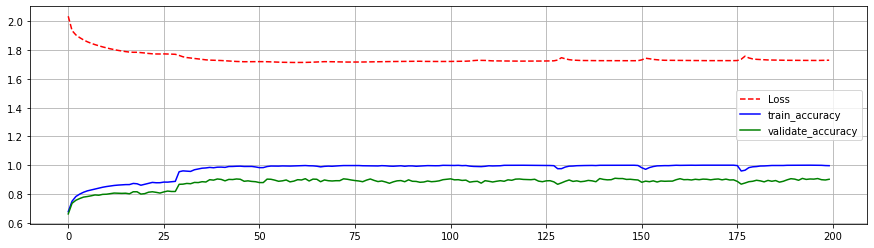

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(Loss,'r--')
plt.plot(train_acc,'b')
plt.plot(validate_acc,'g')
plt.legend(('Loss','train_accuracy','validate_accuracy'))
plt.grid()

In [ ]:
pre=nn.predict(train_data)
accuracy_score(train_label,pre)

0.9965254237288136

In [ ]:
pre=nn.predict(validate_data)
accuracy_score(validate_label,pre)

0.902

In [ ]:
pre_test=nn.predict(test)
f = h5py.File('test_label.h5', 'w')
f.create_dataset('label', data=pre_test)
f.close()

In [ ]:
with h5py.File('/content/test_label.h5','r') as H: 
    predict = np.copy(H['label']) 

In [ ]:
predict.shape

(10000,)